# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [ ]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [ ]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [ ]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

### 1. Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

In [ ]:
class BaselineLM(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes=4,
                 aggregation_type='mean', num_layers=1, bidirectional=False):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.non_lin = nn.Tanh()
        self.projection = nn.Linear(hidden_dim if not bidirectional else 2 * hidden_dim, num_classes)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        if self.aggregation_type == 'max':
            logits = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            logits = output.mean(dim=1)
        else:
            raise ValueError("Inccorect aggregation type")

        logits = self.projection(self.non_lin(logits))

        return logits

In [ ]:
def handle_history(history):
    loss = np.array(history)[:, 0]
    accuracy = np.array(history)[:, 1]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].plot(loss, marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    axes[1].plot(accuracy, marker='o')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')

    plt.grid(True)
    plt.show()

In [ ]:
def train(model, optimizer, criterion, train_loader, num_epochs):
    history = []

    for epoch in range(num_epochs):
        total_correct = 0
        total_loss = 0

        count = 0
        for train_batch in tqdm(train_loader, desc =f"Epoch: {epoch}"):
            input = train_batch['input_ids'].to(device)
            labels = train_batch['label'].to(device)

            optimizer.zero_grad()
            logits = model(input)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (logits.argmax(dim=1) == labels).sum().item()

        mean_loss = total_loss / len(train_loader)
        accuracy = total_correct / (len(train_loader) * train_loader.batch_size)
        print(f"Mean loss: {mean_loss}, accuracy: {accuracy}")
        history.append((mean_loss, accuracy))

    return history

In [ ]:
model = BaselineLM(vocab_size=len(vocab), hidden_dim=256).to(device)
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
history = train(model, optimizer, criterion, train_dataloader, num_epochs=20)

Epoch: 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.44827399634718895, accuracy: 0.847925


Epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.27117615171025194, accuracy: 0.9127916666666667


Epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.22493579573060077, accuracy: 0.92725


Epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.19459883895106614, accuracy: 0.9363


Epoch: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.17364960095298787, accuracy: 0.94235


Epoch: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.15257665455006064, accuracy: 0.9490916666666667


Epoch: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.13764505857583134, accuracy: 0.954025


Epoch: 7:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.12362564688866648, accuracy: 0.9580083333333334


Epoch: 8:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.11148397037054722, accuracy: 0.96225


Epoch: 9:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.10402413785010577, accuracy: 0.9641166666666666


Epoch: 10:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0939581401881141, accuracy: 0.9683416666666667


Epoch: 11:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0882747935838066, accuracy: 0.969975


Epoch: 12:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.08205428182726415, accuracy: 0.9718916666666667


Epoch: 13:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.07718778379591337, accuracy: 0.9736083333333333


Epoch: 14:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.07388322155222607, accuracy: 0.97465


Epoch: 15:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.06812250397624642, accuracy: 0.976275


Epoch: 16:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.06792309427201398, accuracy: 0.9767833333333333


Epoch: 17:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.06564968804413608, accuracy: 0.9775583333333333


Epoch: 18:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.06256258479278962, accuracy: 0.978225


Epoch: 19:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.06221947850457703, accuracy: 0.9791833333333333


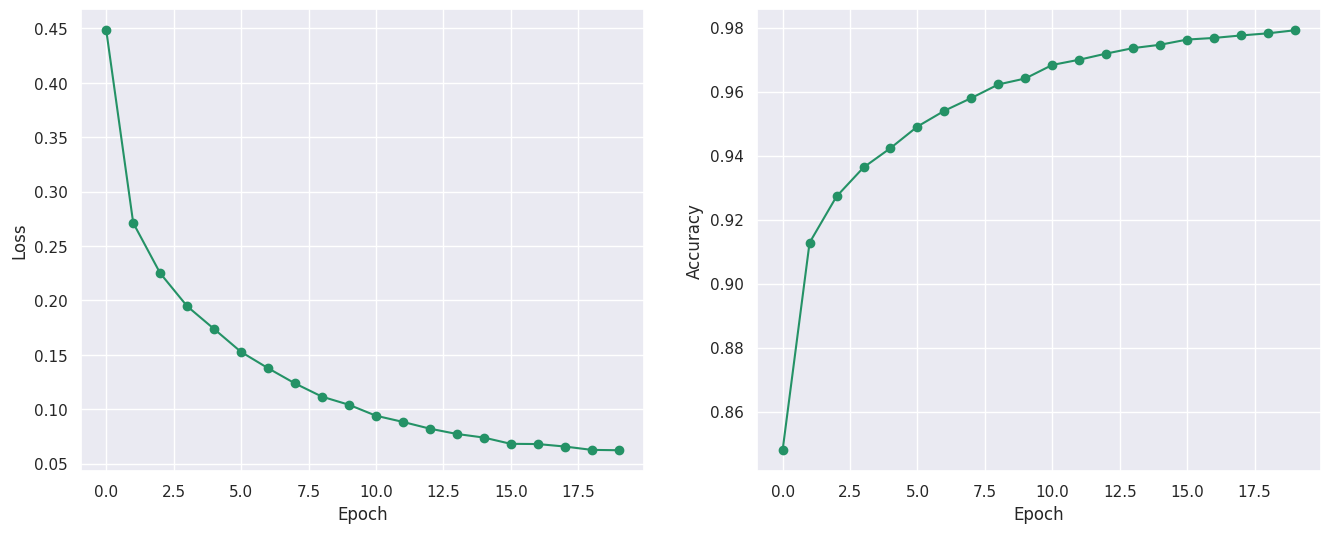

In [ ]:
handle_history(history)

Провалидируемся:

In [ ]:
acc = evaluate(model, eval_dataloader)
print(f"Accuracy: ", round(acc, 3))

Accuracy:  0.884


### 2. Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

#### Эксперимент 1. Увеличим число слоёв RNN

In [ ]:
model = BaselineLM(vocab_size=len(vocab), hidden_dim=256, num_layers=2).to(device)
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
history = train(model, optimizer, criterion, train_dataloader, num_epochs=10)

Epoch: 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.4557586460083723, accuracy: 0.842875


Epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.27658478979369006, accuracy: 0.911075


Epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.22952662378574412, accuracy: 0.92505


Epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.20178737096091112, accuracy: 0.9326166666666666


Epoch: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.1781889039352536, accuracy: 0.940125


Epoch: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.15962623598401746, accuracy: 0.946325


Epoch: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.14576869494418304, accuracy: 0.9502333333333334


Epoch: 7:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.13209468545063088, accuracy: 0.9548166666666666


Epoch: 8:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.12422070061763128, accuracy: 0.9573583333333333


Epoch: 9:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.11368859983493264, accuracy: 0.9610333333333333


Как мы видим, результат лучше не стал. С большим числом слоёв RNN результат будет ухудшаться. Можно предположить, что проблема заключается в затухании градиента.

#### Эксперимент 2. Сделаем RNN biderectional

In [ ]:
model = BaselineLM(vocab_size=len(vocab), hidden_dim=256, bidirectional=True).to(device)
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
history = train(model, optimizer, criterion, train_dataloader, num_epochs=10)

Epoch: 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.4479412274380525, accuracy: 0.8450916666666667


Epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.2728366851275166, accuracy: 0.9128833333333334


Epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.2278841260029624, accuracy: 0.9255


Epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.19786924230282504, accuracy: 0.9349583333333333


Epoch: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.17582799480631947, accuracy: 0.9416833333333333


Epoch: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.1570383365922918, accuracy: 0.947575


Epoch: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.1423253401141148, accuracy: 0.9514166666666667


Epoch: 7:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.1289753825250392, accuracy: 0.9554416666666666


Epoch: 8:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.11777155567854643, accuracy: 0.9595083333333333


Epoch: 9:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.1088142382270967, accuracy: 0.9622083333333333


In [ ]:
acc = evaluate(model, eval_dataloader)
print(f"Accuracy: ", round(acc, 3))

Accuracy:  0.9


Несмотря на меньший accuracy после обучения на 10 эпохах, модель выдаёт больший accuracy на валидации. Попробуем дообучить модуль до 20 эпох в сумме.

In [ ]:
history.append(train(model, optimizer, criterion, train_dataloader, num_epochs=10))

Epoch: 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.10209953063069843, accuracy: 0.9647083333333333


Epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.09448759817200092, accuracy: 0.9672666666666667


Epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0905942180242079, accuracy: 0.9687416666666666


Epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.08781898383999942, accuracy: 0.9690166666666666


Epoch: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.08398805838877646, accuracy: 0.9711083333333334


Epoch: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.08263123059153246, accuracy: 0.9713


Epoch: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.07908889505507735, accuracy: 0.9725


Epoch: 7:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.07986075132096108, accuracy: 0.9719666666666666


Epoch: 8:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.07668210952764687, accuracy: 0.9729166666666667


Epoch: 9:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.07471122418912128, accuracy: 0.9735083333333333


In [ ]:
acc = evaluate(model, eval_dataloader)
print(f"Accuracy: ", round(acc, 3))

Accuracy:  0.888


Таким образом, обученная на 10 эпохах модуль с двусторонней RNN на данный момент показала себя лучше всех.

In [ ]:
history = history[0:10] + history[10]

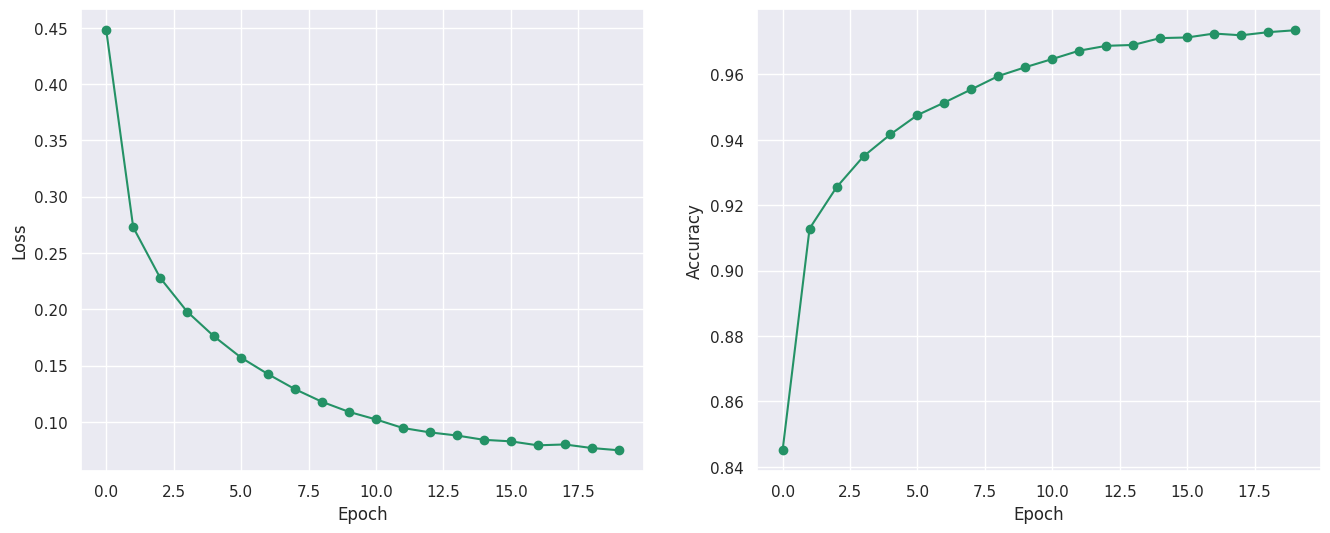

In [ ]:
handle_history(history)

#### Эксперимент 3. Увеличим размер эмбеддингов

In [ ]:
model = BaselineLM(vocab_size=len(vocab), hidden_dim=512, bidirectional=True).to(device)
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
history = train(model, optimizer, criterion, train_dataloader, num_epochs=10)

Epoch: 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.4269339472517371, accuracy: 0.8564416666666667


Epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.273799490839988, accuracy: 0.9109333333333334


Epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.23208619878453512, accuracy: 0.9218833333333334


Epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.20550279306868713, accuracy: 0.9306916666666667


Epoch: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.18479538907731574, accuracy: 0.9363333333333334


Epoch: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.1723877309380099, accuracy: 0.9407416666666667


Epoch: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.1606929170346819, accuracy: 0.943675


Epoch: 7:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.15501845850680646, accuracy: 0.946575


Epoch: 8:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.14959016000727812, accuracy: 0.9469416666666667


Epoch: 9:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.1480264956453815, accuracy: 0.9484666666666667


In [ ]:
acc = evaluate(model, eval_dataloader)
print(f"Accuracy: ", round(acc, 3))

Accuracy:  0.897


#### Эксперимент 4. LSTM

Попробуем побороться с проблемой забывания RNN, воспользовавшись LSTM:

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes=4,
                 aggregation_type='mean', num_layers=1, bidirectional=False):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.non_lin = nn.Tanh()
        self.projection = nn.Linear(hidden_dim if not bidirectional else 2 * hidden_dim, num_classes)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)
        if self.aggregation_type == 'max':
            logits = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            logits = output.mean(dim=1)
        else:
            raise ValueError("Inccorect aggregation type")

        logits = self.projection(self.non_lin(logits))

        return logits

In [ ]:
model = LSTM(vocab_size=len(vocab), hidden_dim=512, bidirectional=True).to(device)
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
history = train(model, optimizer, criterion, train_dataloader, num_epochs=10)

Epoch: 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.3369478200043241, accuracy: 0.8850666666666667


Epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.18532645401184758, accuracy: 0.9358833333333333


Epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.1125283449312672, accuracy: 0.9601333333333333


Epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.062387944235590596, accuracy: 0.9778083333333333


Epoch: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.040766040066171745, accuracy: 0.9861


Epoch: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.031401376712143735, accuracy: 0.9899666666666667


Epoch: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.02735024000601067, accuracy: 0.990975


Epoch: 7:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.023754545093031994, accuracy: 0.9923416666666667


Epoch: 8:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.01977624452306445, accuracy: 0.9939


Epoch: 9:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.01949122140576325, accuracy: 0.993825


In [ ]:
acc = evaluate(model, eval_dataloader)
print(f"Accuracy: ", round(acc, 3))

Accuracy:  0.912


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [ ]:
history = train(model, optimizer, criterion, train_dataloader, num_epochs=10)

Epoch: 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.01004475266973362, accuracy: 0.997325


Epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.002884638882430045, accuracy: 0.999175


Epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0020668932717093262, accuracy: 0.9993666666666666


Epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0015789264938871402, accuracy: 0.999425


Epoch: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0011576430748965057, accuracy: 0.999525


Epoch: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0011040158911293145, accuracy: 0.9995583333333333


Epoch: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.001032354257874826, accuracy: 0.999625


Epoch: 7:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0008837080162656216, accuracy: 0.9996416666666667


Epoch: 8:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.00075241893001714, accuracy: 0.9996333333333334


Epoch: 9:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0007873041706848914, accuracy: 0.99965


In [ ]:
acc = evaluate(model, eval_dataloader)
print(f"Accuracy: ", round(acc, 3))

Accuracy:  0.911


Запустим ещё 10 эпох обучения:

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)

In [ ]:
history = train(model, optimizer, criterion, train_dataloader, num_epochs=10)

Epoch: 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0004986303506564541, accuracy: 0.9997083333333333


Epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.00044328724941112814, accuracy: 0.9997666666666667


Epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.00047277907224507553, accuracy: 0.9997083333333333


Epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0004636574917537496, accuracy: 0.9997166666666667


Epoch: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0004259332574247311, accuracy: 0.9997


Epoch: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.00042777686967574813, accuracy: 0.9997166666666667


Epoch: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.00040221792613773585, accuracy: 0.9996666666666667


Epoch: 7:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0004143880056999521, accuracy: 0.9996833333333334


Epoch: 8:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.0004179195520264765, accuracy: 0.9996916666666666


Epoch: 9:   0%|          | 0/3750 [00:00<?, ?it/s]

Mean loss: 0.00044480349197665334, accuracy: 0.9996666666666667


In [ ]:
acc = evaluate(model, eval_dataloader)
print(f"Accuracy: ", round(acc, 3))

Accuracy:  0.909


#### Эксперимент 5. LSTM с двумя слоями

Добавим логгирование accuracy на валидационной выборке во время обучения:

In [ ]:
import copy

best_model = LSTM(vocab_size=len(vocab), hidden_dim=512, num_layers=2, bidirectional=True).to(device)
best_accuracy = 0

In [ ]:
def train(model, optimizer, criterion, train_loader, num_epochs):
    global best_model, best_accuracy
    history = []

    for epoch in range(num_epochs):
        total_correct = 0
        total_loss = 0

        count = 0
        for train_batch in tqdm(train_loader, desc =f"Epoch: {epoch}"):
            input = train_batch['input_ids'].to(device)
            labels = train_batch['label'].to(device)

            optimizer.zero_grad()
            logits = model(input)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (logits.argmax(dim=1) == labels).sum().item()

        mean_loss = total_loss / len(train_loader)
        accuracy = total_correct / (len(train_loader) * train_loader.batch_size)
        history.append((mean_loss, accuracy))
        print(f"TRAIN: Mean loss: {mean_loss}, accuracy: {accuracy}")
        accuracy = evaluate(model, eval_dataloader)
        print(f"VALIDATION: Accuracy: {accuracy}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model.load_state_dict(copy.deepcopy(model.state_dict()))

    return history

In [ ]:
model = LSTM(vocab_size=len(vocab), hidden_dim=512, num_layers=2, bidirectional=True).to(device)
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [19]:
history = train(model, optimizer, criterion, train_dataloader, num_epochs=10)

Epoch: 0:   0%|          | 0/3750 [00:00<?, ?it/s]

TRAIN: Mean loss: 0.33882869166831175, accuracy: 0.8831916666666667
VALIDATION: Accuracy: 0.9065999984741211


Epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

TRAIN: Mean loss: 0.19220378017053008, accuracy: 0.9342166666666667
VALIDATION: Accuracy: 0.9167999625205994


Epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

TRAIN: Mean loss: 0.1233783736144503, accuracy: 0.957475
VALIDATION: Accuracy: 0.9099999666213989


Epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

TRAIN: Mean loss: 0.07241081203358869, accuracy: 0.974375
VALIDATION: Accuracy: 0.9143999814987183


Epoch: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

TRAIN: Mean loss: 0.048584904927341264, accuracy: 0.9832083333333334
VALIDATION: Accuracy: 0.9081999659538269


Epoch: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

TRAIN: Mean loss: 0.036286055625997446, accuracy: 0.987325
VALIDATION: Accuracy: 0.9088000059127808


Epoch: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

TRAIN: Mean loss: 0.031083265660056106, accuracy: 0.9891166666666666
VALIDATION: Accuracy: 0.9047999978065491


Epoch: 7:   0%|          | 0/3750 [00:00<?, ?it/s]

TRAIN: Mean loss: 0.02617874068754609, accuracy: 0.9911333333333333
VALIDATION: Accuracy: 0.9027999639511108


Epoch: 8:   0%|          | 0/3750 [00:00<?, ?it/s]

TRAIN: Mean loss: 0.024135212889914933, accuracy: 0.9920083333333334
VALIDATION: Accuracy: 0.9083999991416931


Epoch: 9:   0%|          | 0/3750 [00:00<?, ?it/s]

TRAIN: Mean loss: 0.02239651436144219, accuracy: 0.9924
VALIDATION: Accuracy: 0.9043999910354614


In [20]:
acc = evaluate(best_model, eval_dataloader)
print(f"Accuracy: ", round(acc, 3))

Accuracy:  0.917


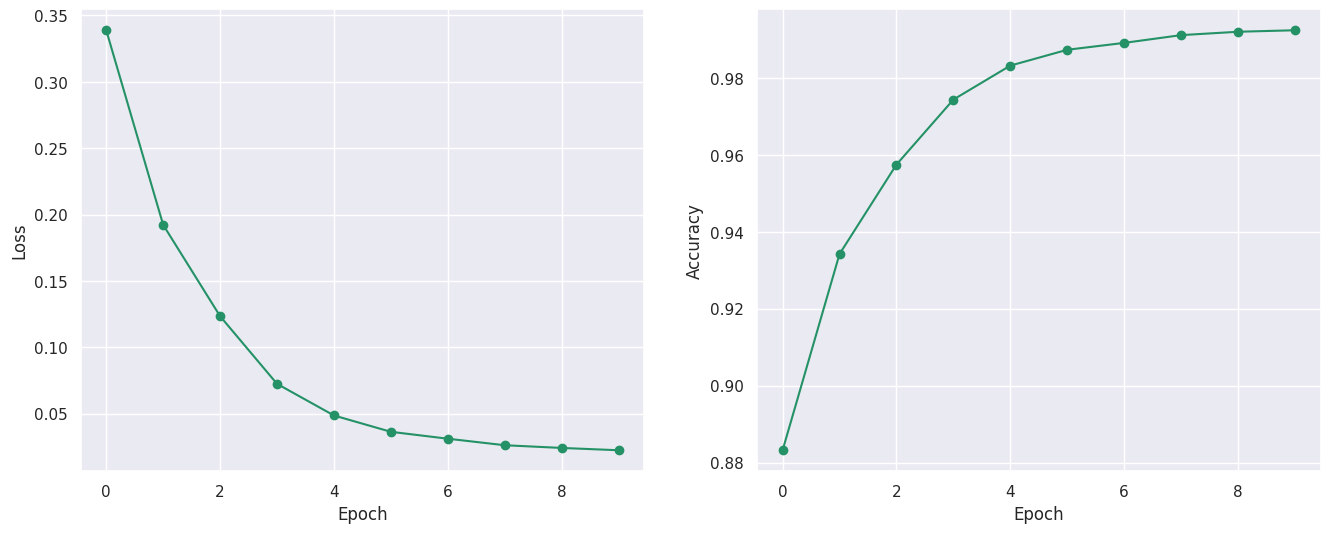

In [21]:
handle_history(history)

### 3. Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### 4. Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Результаты экспериментов:
0. **Baseline-модель с 1-слойной RNN и эмбеддингами размера 256**

    После обучения на 20 эпохах показала на валидационной выборке accuracy 0.884

1. **Baseline-модель с 2-слойной RNN и эмбеддингами размера 256**
    
    Значение accuracy на тренировочной выборке сильно упало, что можно объяснить проблемой затухания градиента

2. **Baseline-модель с 1-слойной двусторонней RNN и эмбеддингами размера 256**

    После обучения на 10 эпохах показала на валидационной выборке accuracy 0.9

3. **Baseline-модель с 1-слойной двусторонней RNN и эмбеддингами размера 512**

    После обучения на 10 эпохах показала на валидационной выборке accuracy 0.897

4. **1-слойная двусторонняя LSTM с эмбеддингами размера 512**

    После обучения на 10 эпохах показала на валидационной выборке accuracy 0.912

5. **2-слойная двусторонняя LSTM с эмбеддингами размера 512**

    После обучения на 2 эпохах показала на валидационной выборке accuracy 0.917.


Таким образом, лучшего качества удалось достичь с использованием 2-слойной двусторонней LSTM с эмбеддингами размера 512, значение accuracy на валидационной выборке равно 0.917.

Замерять значение accuracy на валидационной выборке я начал только в эксперименте с LSTM. Поэтому возможно, что предыдущие конфигурации модели могли выбить скор больше, чем 0.917. Сходимости значения функции потерь (кросс-энтропии) и значения accuracy на тренировочной выборке после каждой эпохи обучения стабильны.

**Замечание.** Я не добавлял dropout в модели, хотя возможно это помогло бы улучшить их обобщающую способность и выбить на валидации больший скор.